In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.optim as optim
import torch.nn as nn
from PIL import Image, ImageDraw
import json
import os
import random
import matplotlib.pyplot as plt

# Custom Dataset Class
class FaceRecognitionDataset(Dataset):
    def __init__(self, annotations, root_dir, transform=None):
        self.annotations = annotations
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_name = list(self.annotations.keys())[idx]
        img_path = os.path.join(self.root_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        original_size = image.size
        sample_annotations = self.annotations[img_name]

        boxes = []
        names = []

        for annotation in sample_annotations:
            face_location = annotation['face_location']
            name = annotation['name']

            # Scale bounding box coordinates
            scale_x = 224.0 / original_size[0]
            scale_y = 224.0 / original_size[1]

            box_scaled = [
                int(face_location['left'] * scale_x),
                int(face_location['top'] * scale_y),
                int(face_location['right'] * scale_x),
                int(face_location['bottom'] * scale_y)
            ]

            boxes.append(box_scaled)
            names.append(name)

        # Apply transformations to the image
        if self.transform:
            image = self.transform(image)

        # Convert list of boxes to tensor
        boxes_tensor = torch.tensor(boxes, dtype=torch.float)

        return image, boxes_tensor, names


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Custom collate function for DataLoader
def collate_fn(batch):
    images = []
    all_boxes = []
    all_names = []
    for b in batch:
        images.append(b[0])
        all_boxes.append(b[1])
        all_names.append(b[2])
    images = torch.stack(images)
    return images, all_boxes, all_names

In [ ]:
# Function to partition dataset
def partition_dataset(annotations, train_frac=0.8, val_frac=0.1):
    total_samples = len(annotations)
    train_size = int(total_samples * train_frac)
    val_size = int(total_samples * val_frac)
    test_size = total_samples - train_size - val_size

    keys = list(annotations.keys())
    random.shuffle(keys)
    train_keys = keys[:train_size]
    val_keys = keys[train_size:train_size + val_size]
    test_keys = keys[train_size + val_size:]

    train_annotations = {k: annotations[k] for k in train_keys}
    val_annotations = {k: annotations[k] for k in val_keys}
    test_annotations = {k: annotations[k] for k in test_keys}

    print(f"Dataset partitioned into {len(train_annotations)} training, {len(val_annotations)} validation, and {len(test_annotations)} test samples.")

    return train_annotations, val_annotations, test_annotations

In [ ]:
!ls "/content/drive/My Drive"


 1636866451977.jpg
 1636866451992.jpg
 1636866452006.jpg
 1636866452019.jpg
 1636866452032.jpg
 1636866452046.jpg
 1636866452060.jpg
 1636866452074.jpg
 1636866452088.jpg
 1636866452102.jpg
 1636866452116.jpg
 1636866452130.jpg
 1636866452144.jpg
 1636866452159.jpg
 19386833452_19957752364.insur
 19386833452_19957752364.pdf
'1ETLGGQL0009809 (1).pdf'
 1ETLGGQL0009809.pdf
 20200829_231440.jpg
 20200829_231522.jpg
'20200829_231833 (1).jpg'
 20200829_231833.jpg
'22EE30028 Subham Ghosh AGFE report (1).docx'
'22EE30028 Subham Ghosh AGFE report.docx'
'9063H Chemistry 11 A3.pdf'
'9063H Computer Science 11 A3.pdf'
'9063H English 11 A3.pdf'
'9063H English.pdf'
'9063H Mathematics 11 A3 (1).pdf'
'9063H Mathematics 11 A3.pdf'
'9063H PhysicalEducation 11 A3.pdf'
'9063H Physics 11 A3.pdf'
'9063H Subham Ghosh 12 B.pdf'
'9063H SubhamGhosh 12 B.pdf'
'9063H SubhamGhosh 12B.pdf'
'9063H SUBHAM GHOSH B 12.pdf'
 annotationsfacedet.json
 Beer___Johnston.gdoc
 Ch18.pdf
 Ch19.pdf
 Ch20.pdf
 ChiSquareXFrames
 Ch

In [ ]:
#Dataset https://drive.google.com/drive/folders/16VdACwgH4RV9HG_DANLIrwBtot6mo1jL?usp=drive_link
#Annotation https://drive.google.com/file/d/1t62A4eDRlAhcZPwQ2rm-z9Tu-zOKUNnj/view?usp=drive_link

In [ ]:
# Load Annotations
annotations_path = '/content/drive/MyDrive/annotationsfacedet.json'  # Replace with your actual annotations file path
with open(annotations_path) as f:
    annotations = json.load(f)

In [ ]:
# Partition the dataset into training, validation, and test sets
train_annotations, val_annotations, test_annotations = partition_dataset(annotations)

Dataset partitioned into 160 training, 20 validation, and 20 test samples.


In [ ]:
# Initialize Dataset and Dataloader
root_dir = '/content/drive/MyDrive/datasetfacedet'  # Replace with your actual images directory path

In [ ]:
# Transforms for training, validation and test datasets
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define datasets
train_dataset = FaceRecognitionDataset(train_annotations, root_dir, transform=train_transform)
val_dataset = FaceRecognitionDataset(val_annotations, root_dir, transform=val_test_transform)
test_dataset = FaceRecognitionDataset(test_annotations, root_dir, transform=val_test_transform)

# Define dataloaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn)

In [ ]:
# Define the inv_normalize transform if you need to visualize images
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

# VGG16 Model (not used for visualization, provided for completeness)
model = models.vgg16(pretrained=False)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, 128)

# Loss function and Optimizer (not used for visualization, provided for completeness)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Visualization of images with bounding boxes and names
def show_image_with_boxes(image, boxes, names):
    draw = ImageDraw.Draw(image)
    for box, name in zip(boxes, names):
        # Draw bounding box and name
        draw.rectangle(((box[0], box[1]), (box[2], box[3])), outline="red", width=2)
        draw.text((box[0], box[1] - 10), name, fill="red")
    return image

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Visualizing the first sample from the first mini-batch...


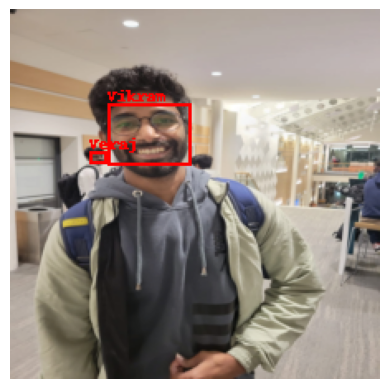

In [ ]:
# Get the first batch from the train loader
first_batch_images, first_batch_boxes, first_batch_names = next(iter(train_loader))

# Apply inverse normalization to the first image in the first batch
first_image = inv_normalize(first_batch_images[0]).clamp(0, 1)
first_image_pil = transforms.ToPILImage()(first_image)

# Visualize the first sample from the first mini-batch
print("Visualizing the first sample from the first mini-batch...")
first_image_with_boxes = show_image_with_boxes(first_image_pil, first_batch_boxes[0], first_batch_names[0])
plt.imshow(first_image_with_boxes)
plt.axis('off')
plt.show()

In [ ]:
vgg16 = models.vgg16(pretrained = True)
vgg16 = vgg16.features

for param in vgg16.parameters():
  param.requires_grad = False

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
model = nn.Sequential(
    vgg16,
    nn.Flatten(),
    nn.Linear(512*7*7, 128),
    nn.ReLU(),
    nn.Linear(128, 4)
)
momentum_coefficient = 0.9
weight_decay = 0.0001
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0005, betas=(momentum_coefficient, 0.999), weight_decay=0.0001)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8, 1, 4])) that is different to the input size (torch.Size([1, 8, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/5], Loss:  13708.3772
Epoch [2/5], Loss:  8351.9204
Epoch [3/5], Loss:  7271.7732
Epoch [4/5], Loss:  7154.4876
Epoch [5/5], Loss:  7106.5987
[13708.377209472656, 8351.920391845702, 7271.773205566406, 7154.487557983399, 7106.598687744141]


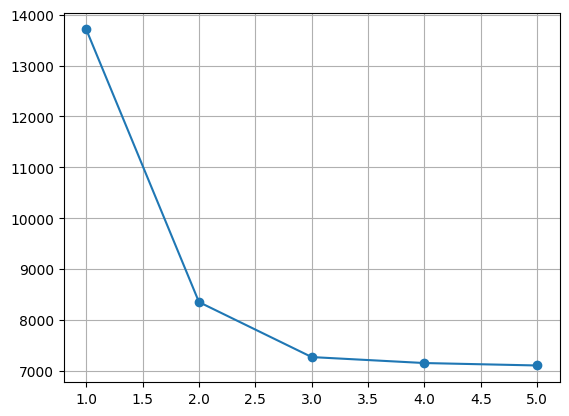

In [ ]:
# Training
EPOCHS = 5
loss_values=[]
for epoch in range(EPOCHS):
  model.train()
  total_loss = 0.0

  ctr=0
  for batch in train_loader:
    image, bounding_box, _ = batch
    num_boxes = batch[0].size(0)
    optimizer.zero_grad()
    outputs = model(image)
    outputs = outputs.view(-1, num_boxes, 4)
    #bounding_box = np.array(bounding_box)
    for i in range(len(bounding_box)):
      if bounding_box[i].numel() == 0:
        #bounding_box[i] = torch.empty(1,4)
        bounding_box[i] = torch.randint(0, 300, (1,4))
      elif bounding_box[i].shape != torch.Size([1, 4]):
        bounding_box[i] = bounding_box[i][:1]


    bounding_box = torch.stack(bounding_box)
    loss = criterion(outputs, bounding_box)
    loss.backward()
    optimizer.step()
    ctr+=1
    #print(loss.item())


    total_loss += loss.item()


  #plt.plot(epoch+1,total_loss/ctr,marker='o', linestyle='-')
  average_loss = total_loss/len(train_loader)
  loss_values.append(average_loss)
  print(f'Epoch [{epoch+1}/{EPOCHS}], Loss: {average_loss: .4f}')
epochs=list(range(1,EPOCHS+1))
print(loss_values)
plt.plot(epochs,loss_values,marker='o', linestyle='-')
plt.grid(True)
plt.show()


In [ ]:
model.eval()
total_loss_val = 0.0

with torch.no_grad():
    for inputs, bounding_boxes,_ in val_loader:
        outputs = model(inputs)
        #outputs = outputs.view(-1, num_boxes, 4)
        #bounding_box = np.array(bounding_box)
        for i in range(len(bounding_boxes)):
          if bounding_box[i].numel() == 0:
            bounding_box[i] == torch.randint(0, 300, (1,4))
          elif bounding_boxes[i].shape != torch.Size([1, 4]):
            bounding_boxes[i] = bounding_boxes[i][:1]

        bounding_boxes = torch.stack(bounding_boxes)
        loss = criterion(outputs, bounding_boxes)
        total_loss_val += loss.item()

    average_loss_val = total_loss_val / len(val_loader)
    print(f"Average Evaluation Loss: {average_loss_val:.4f}")


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8, 1, 4])) that is different to the input size (torch.Size([8, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Average Evaluation Loss: 1300.4676


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4, 1, 4])) that is different to the input size (torch.Size([4, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [ ]:
model = nn.Sequential(
    vgg16,
    nn.Flatten(),
    nn.Linear(512*7*7, 128),
    nn.ReLU(),
    nn.Linear(128, 4)
)
momentum_coefficient = 0.9
weight_decay = 0.0001
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001, betas=(momentum_coefficient, 0.999), weight_decay=0.0001)

Epoch [1/5], Loss:  10809.3064
Epoch [2/5], Loss:  7610.8737
Epoch [3/5], Loss:  7187.1984
Epoch [4/5], Loss:  7212.5208
Epoch [5/5], Loss:  7212.9446
[10809.306369018555, 7610.87373046875, 7187.198416137695, 7212.520809936524, 7212.944555664062]


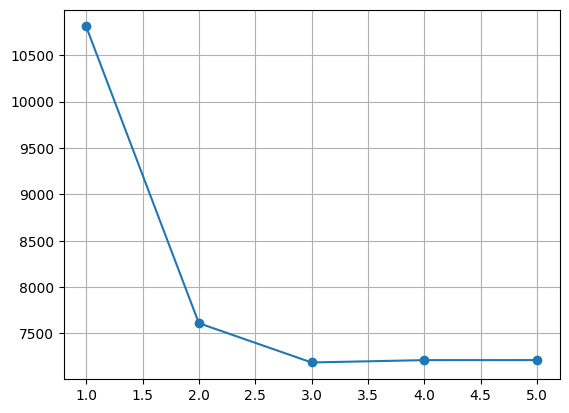

In [ ]:
# Training
EPOCHS = 5
loss_values=[]
for epoch in range(EPOCHS):
  model.train()
  total_loss = 0.0

  ctr=0
  for batch in train_loader:
    image, bounding_box, _ = batch
    num_boxes = batch[0].size(0)
    optimizer.zero_grad()
    outputs = model(image)
    outputs = outputs.view(-1, num_boxes, 4)
    #bounding_box = np.array(bounding_box)
    for i in range(len(bounding_box)):
      if bounding_box[i].numel() == 0:
        #bounding_box[i] = torch.empty(1,4)
        bounding_box[i] = torch.randint(0, 300, (1,4))
      elif bounding_box[i].shape != torch.Size([1, 4]):
        bounding_box[i] = bounding_box[i][:1]


    bounding_box = torch.stack(bounding_box)
    loss = criterion(outputs, bounding_box)
    loss.backward()
    optimizer.step()
    ctr+=1
    #print(loss.item())


    total_loss += loss.item()


  #plt.plot(epoch+1,total_loss/ctr,marker='o', linestyle='-')
  average_loss = total_loss/len(train_loader)
  loss_values.append(average_loss)
  print(f'Epoch [{epoch+1}/{EPOCHS}], Loss: {average_loss: .4f}')
epochs=list(range(1,EPOCHS+1))
print(loss_values)
plt.plot(epochs,loss_values,marker='o', linestyle='-')
plt.grid(True)
plt.show()

In [ ]:
model.eval()
total_loss_val = 0.0

with torch.no_grad():
    for inputs, bounding_boxes,_ in val_loader:
        outputs = model(inputs)
        #outputs = outputs.view(-1, num_boxes, 4)
        #bounding_box = np.array(bounding_box)
        for i in range(len(bounding_boxes)):
          if bounding_box[i].numel() == 0:
            bounding_box[i] == torch.randint(0, 300, (1,4))
          elif bounding_boxes[i].shape != torch.Size([1, 4]):
            bounding_boxes[i] = bounding_boxes[i][:1]

        bounding_boxes = torch.stack(bounding_boxes)
        loss = criterion(outputs, bounding_boxes)
        total_loss_val += loss.item()

    average_loss_val = total_loss_val / len(val_loader)
    print(f"Average Evaluation Loss: {average_loss_val:.4f}")

Average Evaluation Loss: 1358.0850


In [ ]:
model = nn.Sequential(
    vgg16,
    nn.Flatten(),
    nn.Linear(512*7*7, 128),
    nn.ReLU(),
    nn.Linear(128, 4)
)
momentum_coefficient = 0.9
weight_decay = 0.0001
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0001, betas=(momentum_coefficient, 0.999), weight_decay=0.0001)

Epoch [1/5], Loss:  17405.4950
Epoch [2/5], Loss:  14248.5976
Epoch [3/5], Loss:  11548.6916
Epoch [4/5], Loss:  9300.9840
Epoch [5/5], Loss:  8197.5447
[17405.494995117188, 14248.597595214844, 11548.691552734375, 9300.984045410156, 8197.544714355468]


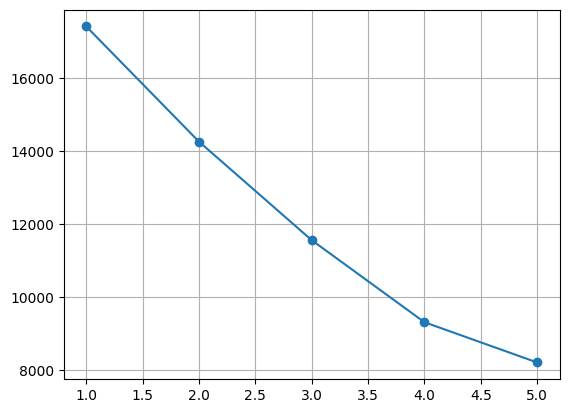

In [ ]:
# Training
EPOCHS = 5
loss_values=[]
for epoch in range(EPOCHS):
  model.train()
  total_loss = 0.0

  ctr=0
  for batch in train_loader:
    image, bounding_box, _ = batch
    num_boxes = batch[0].size(0)
    optimizer.zero_grad()
    outputs = model(image)
    outputs = outputs.view(-1, num_boxes, 4)
    #bounding_box = np.array(bounding_box)
    for i in range(len(bounding_box)):
      if bounding_box[i].numel() == 0:
        #bounding_box[i] = torch.empty(1,4)
        bounding_box[i] = torch.randint(0, 300, (1,4))
      elif bounding_box[i].shape != torch.Size([1, 4]):
        bounding_box[i] = bounding_box[i][:1]


    bounding_box = torch.stack(bounding_box)
    loss = criterion(outputs, bounding_box)
    loss.backward()
    optimizer.step()
    ctr+=1
    #print(loss.item())


    total_loss += loss.item()


  #plt.plot(epoch+1,total_loss/ctr,marker='o', linestyle='-')
  average_loss = total_loss/len(train_loader)
  loss_values.append(average_loss)
  print(f'Epoch [{epoch+1}/{EPOCHS}], Loss: {average_loss: .4f}')
epochs=list(range(1,EPOCHS+1))
print(loss_values)
plt.plot(epochs,loss_values,marker='o', linestyle='-')
plt.grid(True)
plt.show()

In [ ]:
model.eval()
total_loss_val = 0.0

with torch.no_grad():
    for inputs, bounding_boxes,_ in val_loader:
        outputs = model(inputs)
        #outputs = outputs.view(-1, num_boxes, 4)
        #bounding_box = np.array(bounding_box)
        for i in range(len(bounding_boxes)):
          if bounding_box[i].numel() == 0:
            bounding_box[i] == torch.randint(0, 300, (1,4))
          elif bounding_boxes[i].shape != torch.Size([1, 4]):
            bounding_boxes[i] = bounding_boxes[i][:1]

        bounding_boxes = torch.stack(bounding_boxes)
        loss = criterion(outputs, bounding_boxes)
        total_loss_val += loss.item()

    average_loss_val = total_loss_val / len(val_loader)
    print(f"Average Evaluation Loss: {average_loss_val:.4f}")

Average Evaluation Loss: 1712.6173


Visualizing the first sample from the first mini-batch...


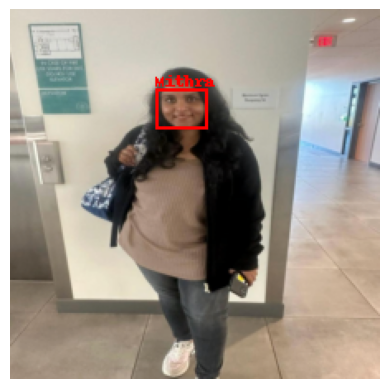

In [ ]:

# Get the first batch from the train loader
first_batch_images, first_batch_boxes, first_batch_names = next(iter(test_loader))

# Apply inverse normalization to the first image in the first batch
first_image = inv_normalize(first_batch_images[2]).clamp(0, 1)
first_image_pil = transforms.ToPILImage()(first_image)

# Visualize the first sample from the first mini-batch
print("Visualizing the first sample from the first mini-batch...")
first_image_with_boxes = show_image_with_boxes(first_image_pil, first_batch_boxes[2], first_batch_names[2])
plt.imshow(first_image_with_boxes)
plt.axis('off')
plt.show()


In [ ]:
output_test = model(first_batch_images)

In [ ]:
output = torch.tensor([[139.1185, 98.7528, 178.9293, 132.6456]])

In [ ]:
import numpy as np
output_test[3]

tensor([72.8685, 53.0497, 77.9079, 67.3810], grad_fn=<SelectBackward0>)

In [ ]:
first_batch_boxes[3]

tensor([[101.,  69., 160., 102.]])

In [ ]:
first_batch_images[0]

tensor([[[-0.4397, -0.5082, -0.5596,  ..., -0.0629, -0.4226, -0.5938],
         [-0.7479, -0.7479, -0.5082,  ..., -0.5938, -0.8335, -0.7308],
         [-1.0562, -1.0390, -0.4911,  ..., -0.9363, -0.7822, -0.4397],
         ...,
         [-0.1828, -0.0458, -0.3027,  ...,  1.9064,  1.9064,  1.8893],
         [-0.1143, -0.1657, -0.3883,  ...,  1.8550,  1.8722,  1.8893],
         [-0.0287,  0.0741,  0.1426,  ...,  1.8550,  1.8893,  1.9064]],

        [[ 0.0826, -0.0049, -0.1275,  ...,  0.3627, -0.0049, -0.1800],
         [-0.2150, -0.2500, -0.0924,  ..., -0.1800, -0.4251, -0.3200],
         [-0.5476, -0.5476, -0.0924,  ..., -0.5301, -0.3901, -0.0224],
         ...,
         [ 0.3978,  0.5203,  0.3102,  ...,  1.8508,  1.8508,  1.8333],
         [ 0.4503,  0.3978,  0.2052,  ...,  1.7983,  1.8158,  1.8333],
         [ 0.5028,  0.6429,  0.7479,  ...,  1.7983,  1.8333,  1.8508]],

        [[-1.0550, -1.1247, -1.2293,  ..., -0.6193, -1.0027, -1.1770],
         [-1.3513, -1.3861, -1.1944,  ..., -1

In [ ]:
output_test[3][0]

tensor(72.8685, grad_fn=<SelectBackward0>)

Visualizing the first sample from the first mini-batch...


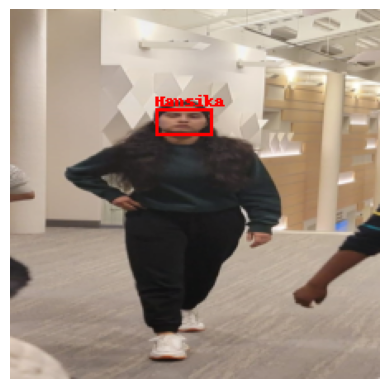

In [ ]:
# Apply inverse normalization to the first image in the first batch
first_image = inv_normalize(first_batch_images[4]).clamp(0, 1)
first_image_pil = transforms.ToPILImage()(first_image)

# Visualize the first sample from the first mini-batch
print("Visualizing the first sample from the first mini-batch...")
first_image_with_boxes = show_image_with_boxes(first_image_pil, first_batch_boxes[4], first_batch_names[4])
plt.imshow(first_image_with_boxes)
plt.axis('off')
plt.show()

In [ ]:
# Get the output batch from the train loader
output_batch_images, output_batch_boxes, output_batch_names = next(iter(train_loader))

# Apply inverse normalization to the output image in the first batch
output_image = inv_normalize(output_batch_images[0]).clamp(0, 1)
output_image_pil = transforms.ToPILImage()(output_image)

# Visualize the first sample from the first mini-batch
print("This is the model output...")
first_image_with_boxes = show_image_with_boxes(output_image_pil, output_batch_boxes[0], output_batch_names[0])
plt.imshow(first_image_with_boxes)
plt.axis('off')
plt.show()

In [ ]:
!pip install ray


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 MB 7.8 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import ray
from ray import tune

In [ ]:
# Define your model architecture
class CustomModel(nn.Module):
    def __init__(self, vgg16):
        super(CustomModel, self).__init__()
        self.vgg16 = vgg16
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(512*7*7, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 4)

    def forward(self, x):
        x = self.vgg16(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [ ]:
config = {
    "vgg16": vgg16,  # Replace 'vgg16' with your VGG16 model
    "lr": tune.loguniform(1e-5, 1e-3),
    "momentum_coefficient": tune.uniform(0.8, 0.99),
    "weight_decay": tune.loguniform(1e-5, 1e-3),
    "epochs": 6
    # Add more hyperparameters as needed
}

In [ ]:
# Define the training function for Ray Tune
def train(config):
    vgg16 = config["vgg16"]  # Assuming vgg16 is provided through the config
    model = CustomModel(vgg16)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(
        model.parameters(),
        lr=config["lr"],
        betas=(config["momentum_coefficient"], 0.999),
        weight_decay=config["weight_decay"]
    )
    epochs = config["epochs"]  # Get number of epochs from config

    for epoch in range(epochs):
      # Training steps here
      for batch_idx, batch in enumerate(train_loader):
        data, target = batch[0], batch[1][0]
        # Your training logic here
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()


        # Optionally, you can report the loss for each iteration or epoch using tune.report()
        tune.report(loss=loss.item())


    model.eval()
    total_loss_val = 0.0

    with torch.no_grad():
      for inputs, bounding_boxes,_ in val_loader:
        outputs = model(inputs)
        #outputs = outputs.view(-1, num_boxes, 4)
        #bounding_box = np.array(bounding_box)
        for i in range(len(bounding_boxes)):
           if bounding_box[i].numel() == 0:
            bounding_box[i] == torch.randint(0, 300, (1,4))
           elif bounding_boxes[i].shape != torch.Size([1, 4]):
            bounding_boxes[i] = bounding_boxes[i][:1]

        bounding_boxes = torch.stack(bounding_boxes)
        loss = criterion(outputs, bounding_boxes)
        total_loss_val += loss.item()


      average_loss_val = total_loss_val / len(val_loader)
      print(f"Average Evaluation Loss: {average_loss_val:.4f}")














In [ ]:
for batch_idx, batch in enumerate(train_loader):
    print(type(batch))  # Check the type of the batch
    print(len(batch))   # Check the number of elements in the batch
    print(type(batch[0]))  # Check the type of the first element
    print(type(batch[1]))  # Check the type of the second element


<class 'tuple'>
3
<class 'torch.Tensor'>
<class 'list'>
<class 'tuple'>
3
<class 'torch.Tensor'>
<class 'list'>
<class 'tuple'>
3
<class 'torch.Tensor'>
<class 'list'>
<class 'tuple'>
3
<class 'torch.Tensor'>
<class 'list'>
<class 'tuple'>
3
<class 'torch.Tensor'>
<class 'list'>
<class 'tuple'>
3
<class 'torch.Tensor'>
<class 'list'>
<class 'tuple'>
3
<class 'torch.Tensor'>
<class 'list'>
<class 'tuple'>
3
<class 'torch.Tensor'>
<class 'list'>
<class 'tuple'>
3
<class 'torch.Tensor'>
<class 'list'>
<class 'tuple'>
3
<class 'torch.Tensor'>
<class 'list'>
<class 'tuple'>
3
<class 'torch.Tensor'>
<class 'list'>
<class 'tuple'>
3
<class 'torch.Tensor'>
<class 'list'>
<class 'tuple'>
3
<class 'torch.Tensor'>
<class 'list'>
<class 'tuple'>
3
<class 'torch.Tensor'>
<class 'list'>
<class 'tuple'>
3
<class 'torch.Tensor'>
<class 'list'>
<class 'tuple'>
3
<class 'torch.Tensor'>
<class 'list'>
<class 'tuple'>
3
<class 'torch.Tensor'>
<class 'list'>
<class 'tuple'>
3
<class 'torch.Tensor'>
<class 

In [ ]:
ray.init(num_cpus=2, num_gpus=1)

2023-12-07 20:08:28,462	INFO worker.py:1673 -- Started a local Ray instance.


Python version:,3.10.12
Ray version:,2.8.1


In [ ]:
!pip install tensorboardX


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 919.2 kB/s eta 0:00:00


In [ ]:
# Assuming train_loader is your DataLoader
batch = next(iter(train_loader))
data = batch[0][0]  # Accessing the first data tensor within the batch
target = batch[1][0]  # Accessing the first target tensor within the batch

print(data.shape)  # Check the shape of the data tensor
print(target.shape)  # Check the shape of the target tensor



torch.Size([3, 224, 224])
torch.Size([1, 4])


In [ ]:
import os

# Set the environment variable to disable the new output engine
os.environ["RAY_AIR_NEW_OUTPUT"] = "0"


In [ ]:
analysis = tune.run(
    train,
    config=config,
    num_samples=10
)


== Status ==
Current time: 2023-12-07 20:09:44 (running for 00:00:53.49)
Using FIFO scheduling algorithm.
Logical resource usage: 2.0/2 CPUs, 0/1 GPUs
Result logdir: /root/ray_results/train_2023-12-07_20-08-50
Number of trials: 10/10 (10 PENDING)
+-------------------+----------+-------+-------------+------------------------+----------------+
| Trial name        | status   | loc   |          lr |   momentum_coefficient |   weight_decay |
|-------------------+----------+-------+-------------+------------------------+----------------|
| train_6fe62_00000 | PENDING  |       | 3.13179e-05 |               0.844848 |    0.000445696 |
| train_6fe62_00001 | PENDING  |       | 5.16973e-05 |               0.824168 |    0.00036276  |
| train_6fe62_00002 | PENDING  |       | 0.000515469 |               0.95508  |    1.09578e-05 |
| train_6fe62_00003 | PENDING  |       | 1.08021e-05 |               0.954467 |    2.28906e-05 |
| train_6fe62_00004 | PENDING  |       | 0.000969101 |               0.988

(train pid=41726) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([3, 4])) that is different to the input size (torch.Size([8, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
(train pid=41726)   return F.mse_loss(input, target, reduction=self.reduction)
2023-12-07 20:10:12,731	ERROR tune_controller.py:1383 -- Trial task failed for trial train_6fe62_00001
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/r

Result for train_6fe62_00001:
  date: 2023-12-07_20-09-45
  hostname: 8d5ae1b7a5ee
  node_ip: 172.28.0.12
  pid: 41726
  timestamp: 1701979785
  trial_id: 6fe62_00001
  
Result for train_6fe62_00000:
  date: 2023-12-07_20-09-45
  hostname: 8d5ae1b7a5ee
  node_ip: 172.28.0.12
  pid: 41725
  timestamp: 1701979785
  trial_id: 6fe62_00000
  
== Status ==
Current time: 2023-12-07 20:10:14 (running for 00:01:23.85)
Using FIFO scheduling algorithm.
Logical resource usage: 1.0/2 CPUs, 0/1 GPUs
Result logdir: /root/ray_results/train_2023-12-07_20-08-50
Number of trials: 10/10 (2 ERROR, 8 PENDING)
+-------------------+----------+-------------------+-------------+------------------------+----------------+
| Trial name        | status   | loc               |          lr |   momentum_coefficient |   weight_decay |
|-------------------+----------+-------------------+-------------+------------------------+----------------|
| train_6fe62_00002 | PENDING  |                   | 0.000515469 |            

(train pid=42166) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([2, 4])) that is different to the input size (torch.Size([8, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size. [repeated 2x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(train pid=42166)   return F.mse_loss(input, target, reduction=self.reduction) [repeated 2x across cluster]
2023-12-07 20:10:37,068	ERROR tune_controller.py:1383 -- Trial task failed for trial train_6fe62_00003
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook

Result for train_6fe62_00003:
  date: 2023-12-07_20-10-27
  hostname: 8d5ae1b7a5ee
  node_ip: 172.28.0.12
  pid: 42166
  timestamp: 1701979827
  trial_id: 6fe62_00003
  


2023-12-07 20:10:37,315	ERROR tune_controller.py:1383 -- Trial task failed for trial train_6fe62_00002
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 2563, in get
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(RuntimeError): ray::ImplicitFunc.train() (pid=42165, ip=172.28.0.12, actor_id=d3f750870f72c962be3ea12c01000000, repr=train)
  File "/usr/local/lib/python3.10/dist-packages/ray/tune/trainable/trainable.py", line 342, in train
    raise skipped from exception_cause(skipped)
 

Result for train_6fe62_00002:
  date: 2023-12-07_20-10-27
  hostname: 8d5ae1b7a5ee
  node_ip: 172.28.0.12
  pid: 42165
  timestamp: 1701979827
  trial_id: 6fe62_00002
  
== Status ==
Current time: 2023-12-07 20:10:39 (running for 00:01:49.02)
Using FIFO scheduling algorithm.
Logical resource usage: 0/2 CPUs, 0/1 GPUs
Result logdir: /root/ray_results/train_2023-12-07_20-08-50
Number of trials: 10/10 (4 ERROR, 6 PENDING)
+-------------------+----------+-------------------+-------------+------------------------+----------------+
| Trial name        | status   | loc               |          lr |   momentum_coefficient |   weight_decay |
|-------------------+----------+-------------------+-------------+------------------------+----------------|
| train_6fe62_00004 | PENDING  |                   | 0.000969101 |               0.988419 |    0.000130627 |
| train_6fe62_00005 | PENDING  |                   | 1.07763e-05 |               0.953252 |    3.29935e-05 |
| train_6fe62_00006 | PENDING  |

(train pid=42382) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 4])) that is different to the input size (torch.Size([8, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size. [repeated 2x across cluster]
(train pid=42382)   return F.mse_loss(input, target, reduction=self.reduction) [repeated 2x across cluster]
2023-12-07 20:11:07,618	ERROR tune_controller.py:1383 -- Trial task failed for trial train_6fe62_00005
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, *

Result for train_6fe62_00005:
  date: 2023-12-07_20-10-53
  hostname: 8d5ae1b7a5ee
  node_ip: 172.28.0.12
  pid: 42382
  timestamp: 1701979853
  trial_id: 6fe62_00005
  


2023-12-07 20:11:07,856	ERROR tune_controller.py:1383 -- Trial task failed for trial train_6fe62_00004
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 2563, in get
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(DeprecationWarning): ray::ImplicitFunc.train() (pid=42380, ip=172.28.0.12, actor_id=bb1319c0a6d3d88b61905ae001000000, repr=train)
  File "/usr/local/lib/python3.10/dist-packages/ray/tune/trainable/trainable.py", line 342, in train
    raise skipped from exception_cause(skip

Result for train_6fe62_00004:
  date: 2023-12-07_20-10-53
  hostname: 8d5ae1b7a5ee
  node_ip: 172.28.0.12
  pid: 42380
  timestamp: 1701979853
  trial_id: 6fe62_00004
  
== Status ==
Current time: 2023-12-07 20:11:09 (running for 00:02:19.33)
Using FIFO scheduling algorithm.
Logical resource usage: 2.0/2 CPUs, 0/1 GPUs
Result logdir: /root/ray_results/train_2023-12-07_20-08-50
Number of trials: 10/10 (6 ERROR, 4 PENDING)
+-------------------+----------+-------------------+-------------+------------------------+----------------+
| Trial name        | status   | loc               |          lr |   momentum_coefficient |   weight_decay |
|-------------------+----------+-------------------+-------------+------------------------+----------------|
| train_6fe62_00006 | PENDING  |                   | 0.00027713  |               0.829123 |    0.000465248 |
| train_6fe62_00007 | PENDING  |                   | 0.000303568 |               0.847288 |    3.20865e-05 |
| train_6fe62_00008 | PENDING 

(train pid=42612) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 4])) that is different to the input size (torch.Size([8, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size. [repeated 2x across cluster]
(train pid=42612)   return F.mse_loss(input, target, reduction=self.reduction) [repeated 2x across cluster]
2023-12-07 20:11:33,039	ERROR tune_controller.py:1383 -- Trial task failed for trial train_6fe62_00007
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, *

Result for train_6fe62_00007:
  date: 2023-12-07_20-11-19
  hostname: 8d5ae1b7a5ee
  node_ip: 172.28.0.12
  pid: 42612
  timestamp: 1701979879
  trial_id: 6fe62_00007
  


2023-12-07 20:11:33,379	ERROR tune_controller.py:1383 -- Trial task failed for trial train_6fe62_00006
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 2563, in get
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(DeprecationWarning): ray::ImplicitFunc.train() (pid=42606, ip=172.28.0.12, actor_id=807f670b6e0f3c130f46469e01000000, repr=train)
  File "/usr/local/lib/python3.10/dist-packages/ray/tune/trainable/trainable.py", line 342, in train
    raise skipped from exception_cause(skip

Result for train_6fe62_00006:
  date: 2023-12-07_20-11-19
  hostname: 8d5ae1b7a5ee
  node_ip: 172.28.0.12
  pid: 42606
  timestamp: 1701979879
  trial_id: 6fe62_00006
  
== Status ==
Current time: 2023-12-07 20:11:35 (running for 00:02:44.69)
Using FIFO scheduling algorithm.
Logical resource usage: 0/2 CPUs, 0/1 GPUs
Result logdir: /root/ray_results/train_2023-12-07_20-08-50
Number of trials: 10/10 (8 ERROR, 2 PENDING)
+-------------------+----------+-------------------+-------------+------------------------+----------------+
| Trial name        | status   | loc               |          lr |   momentum_coefficient |   weight_decay |
|-------------------+----------+-------------------+-------------+------------------------+----------------|
| train_6fe62_00008 | PENDING  |                   | 4.13248e-05 |               0.829229 |    1.63435e-05 |
| train_6fe62_00009 | PENDING  |                   | 0.000399759 |               0.841509 |    0.000691716 |
| train_6fe62_00000 | ERROR    |

(train pid=42824) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([2, 4])) that is different to the input size (torch.Size([8, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size. [repeated 2x across cluster]
(train pid=42824)   return F.mse_loss(input, target, reduction=self.reduction) [repeated 2x across cluster]
2023-12-07 20:11:59,454	ERROR tune_controller.py:1383 -- Trial task failed for trial train_6fe62_00009
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, *

Result for train_6fe62_00009:
  date: 2023-12-07_20-11-48
  hostname: 8d5ae1b7a5ee
  node_ip: 172.28.0.12
  pid: 42824
  timestamp: 1701979908
  trial_id: 6fe62_00009
  
Result for train_6fe62_00008:
  date: 2023-12-07_20-11-48
  hostname: 8d5ae1b7a5ee
  node_ip: 172.28.0.12
  pid: 42822
  timestamp: 1701979908
  trial_id: 6fe62_00008
  
== Status ==
Current time: 2023-12-07 20:12:28 (running for 00:03:38.31)
Using FIFO scheduling algorithm.
Logical resource usage: 1.0/2 CPUs, 0/1 GPUs
Result logdir: /root/ray_results/train_2023-12-07_20-08-50
Number of trials: 10/10 (10 ERROR)
+-------------------+----------+-------------------+-------------+------------------------+----------------+
| Trial name        | status   | loc               |          lr |   momentum_coefficient |   weight_decay |
|-------------------+----------+-------------------+-------------+------------------------+----------------|
| train_6fe62_00000 | ERROR    | 172.28.0.12:41725 | 3.13179e-05 |               0.84484

TuneError: ignored

In [ ]:
#best_config = analysis.get_best_config(metric="mean_loss", mode="min")

In [ ]:
'''
print(best_config)
ray.shutdown()
'''

'\nprint(best_config)\nray.shutdown()\n'

In [ ]:
ray.shutdown()

In [ ]:
'''
import matplotlib.pyplot as plt

# Assuming 'analysis' is the result from tune.run()
dfs = analysis.trial_dataframes

for trial in dfs:
    df = dfs[trial]
    plt.plot(df["epoch"], df["mean_loss"], label=f"Trial {trial}")

plt.xlabel("Epochs")
plt.ylabel("Mean Loss")
plt.title("Loss vs. Epochs")
plt.legend()
plt.show()
'''

'\nimport matplotlib.pyplot as plt\n\n# Assuming \'analysis\' is the result from tune.run()\ndfs = analysis.trial_dataframes\n\nfor trial in dfs:\n    df = dfs[trial]\n    plt.plot(df["epoch"], df["mean_loss"], label=f"Trial {trial}")\n\nplt.xlabel("Epochs")\nplt.ylabel("Mean Loss")\nplt.title("Loss vs. Epochs")\nplt.legend()\nplt.show()\n'